Airbnb Open data analysis Project
---

This is the first project in the series of Udacity Data scientist nanodegree

### Business Understanding

#### The Goal is to communicate findings from data in a blog in clear manner.

#### Context   
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Boston, MA.

#### Content
The following Airbnb activity is included in this Boston dataset:

Listings, including full descriptions and average review score
Reviews, including unique id for each reviewer and detailed comments
Calendar, including listing id and the price and availability for that day

Analysis is based on data for 2016.09-2017.09

### Questions

* Question 1: What is the availabilty of apartments in Boston yearwise (2016.09-2017.09)?
* Question 2: What are the main factors impacting price?
* Question 3: What is the sentiment difference in apartment descriptions vs reviews by guests?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk

import pytest
import datetime as dt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn import preprocessing
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  

from wordcloud import WordCloud


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [2]:
path_data = os.getcwd()+'/Data'

### Import and understand Data

In [11]:
calendar = pd.read_csv(path_data+'/calendar.csv')
listings = pd.read_csv(path_data+'/listings.csv')
reviews = pd.read_csv(path_data+'/reviews.csv')

In [12]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [13]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [14]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


### Question1: What is the availabilty of apartments in Boston yearwise (2016.09-2017.09)?

#### Prepare Data

In [15]:
def price_to_int(df):
    '''Converting price column to float after removing dollar sign. '''
    df['price'] = df['price'].replace('\$','',regex = True)
    df['price'] = df['price'].replace(',','',regex = True)
    df['price'] = df['price'].replace('\$','',regex = True).astype(float)
    return df

In [16]:
calendar['available'] = np.where(calendar['available'] == 'f', False,True)
# convert availabilty column to boolean
calendar = price_to_int(df = calendar) # convert price column to integer datatype
calendar = calendar.astype({'date':'datetime64[ns]' }) # convert date column to datetime
calendar = calendar.drop_duplicates() # drop duplicated columns
calendar.insert(4,'weekday',value = calendar['date'].dt.weekday) # insert weekday column to dataframe
calendar.insert(5, 'month', value = calendar['date'].dt.month) #insert month column to dataframe

#### Analysis of question 1

In [17]:
t = round(calendar[calendar['available'] == False].shape[0]/calendar.shape[0],2)*100 
print( f'Total avaliability of listed apartments throughout the Year is {t}%')

Total avaliability of listed apartments throughout the Year is 51.0%


In [20]:
def show_values_on_bars(axs):
    ''' This function is used to show values at the top of the bars with '''
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + (p.get_height() *0.01)
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        sns.set_theme(style = 'dark', context="notebook")
        

def plot_availability():
    '''
    This function plots the total availabilty throughout the year and save the plot
    '''
    d_dims = (8, 6)
    # df = mylib.load_data()
    fig, ax = plt.subplots(figsize=d_dims)
    total_avail = calendar['available'].value_counts().reset_index()
    total_avail['available %'] = round(total_avail['available']/total_avail['available'].sum()*100,2)

    ax = sns.barplot(data = total_avail, x = 'index', y = 'available %');
    ax.set(xlabel = None)
    ax.set_title('Total availability of Properties (2016.09-2017.09)')
    ax.axhline(0)
    show_values_on_bars(ax)
    fig.savefig('total_availability.png')

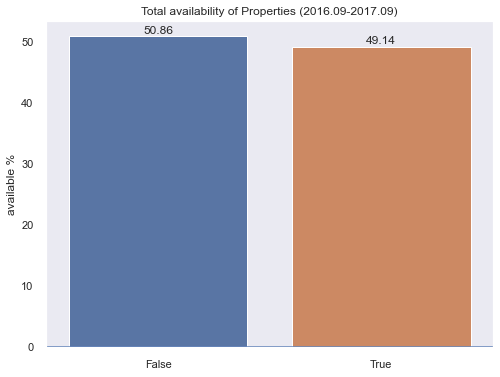

In [23]:
plot_availability()

In [24]:
def plot_by_timeperiod(time_column, plot_title, x_label, color_x,plot_id, axes_x):
    
    '''
    This function plots the barchart of availability along different dimensions where value is the count/1000
    '''
    df_count = calendar.groupby(time_column, as_index = False)['available'].sum().rename(columns = {'available':'count'})
    df_count.insert(2,'count /1000', df_count['count']/1000)
    axes[plot_id] = sns.barplot(data = df_count, x = time_column, y = 'count /1000', color = color_x, ax = axes_x);
    axes[plot_id].set_title(plot_title);
    axes[plot_id].set_xlabel(x_label);
    axes[plot_id].set_ylabel('Count /1000');
    show_values_on_bars(axes[plot_id]);

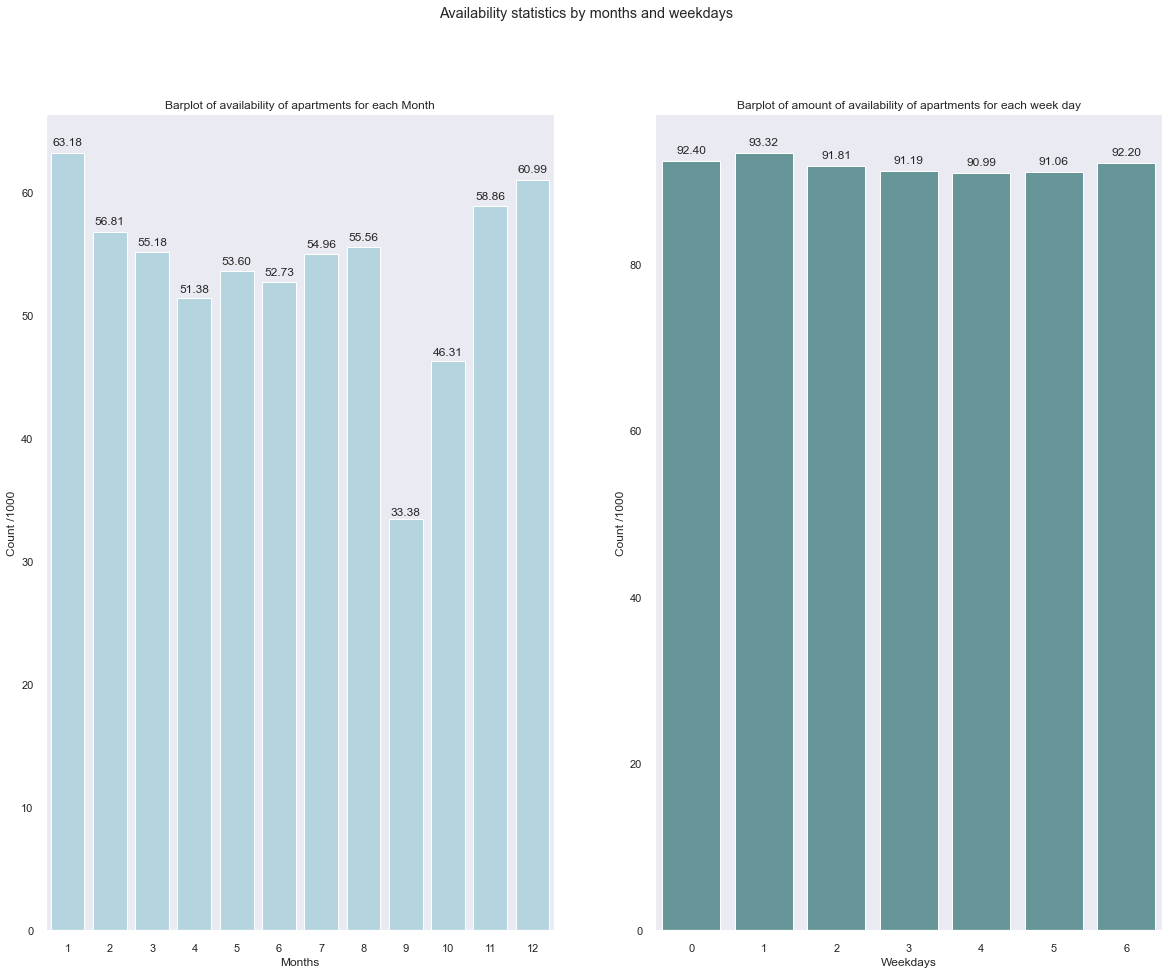

In [25]:
fig, axes = plt.subplots(1,2, figsize = (20,15)); # plot two barcharts by different time dimensions
fig.suptitle('Availability statistics by months and weekdays');

plot_by_timeperiod(time_column = 'month',
               plot_title = 'Barplot of availability of apartments for each Month',
               x_label = 'Months',
               color_x = 'lightblue',plot_id = 0, axes_x = axes[0])

plot_by_timeperiod(time_column = 'weekday',
               plot_title = 'Barplot of amount of availability of apartments for each week day',
               x_label = 'Weekdays',
                color_x = 'cadetblue',plot_id = 1, axes_x = axes[1])

fig.savefig('By months and weekdays.png') #save the plot

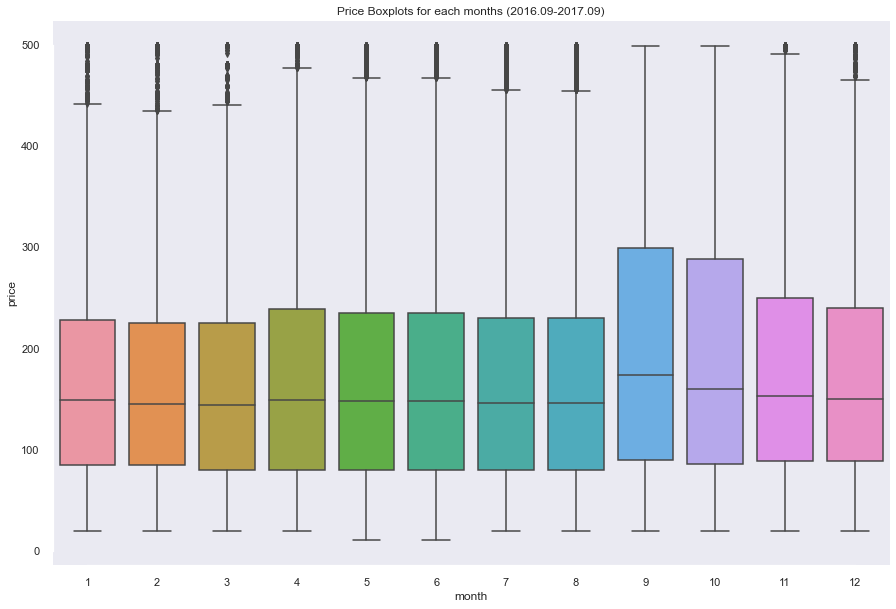

In [26]:
# plot boxplots of Prices along months
d_dims = (15, 10)
fig, ax = plt.subplots(figsize=d_dims)
sns.set_theme(style = 'dark', context="notebook")
sns.set(rc={'figure.figsize':(15,8.27)})
ax = sns.boxplot(data = calendar[calendar['price'] < 500], x = 'month', y = 'price');
ax.set_title('Price Boxplots for each months (2016.09-2017.09)')
sns.despine( trim=True);
fig.savefig('Price by months.png')

#### Brief: 
* Overall, total avaliability of listed apartments throughout the Year is 51.0%. 
* Availability is uniform along the months and weekdays. 
* However, there are availability decreases in September and October, which is instantly displayed by increae of UpperQuartile of Price boxplots for these months

### Question2: What are the main factors impacting price?

#### Analysis of question 2

In [27]:
market_size = round(calendar.loc[calendar['available'] == True]['price'].sum()/1000000,1)
ave_price = round(calendar.loc[calendar['available'] == True]['price'].sum()/calendar.loc[calendar['available'] == True,:].shape[0],1)
print(f"Market size of Airbnb in Boston is {market_size} mln. $, and average rent price is {ave_price}." )

Market size of Airbnb in Boston is 127.6 mln. $, and average rent price is 198.4.


In [29]:
listings = price_to_int(df = listings)

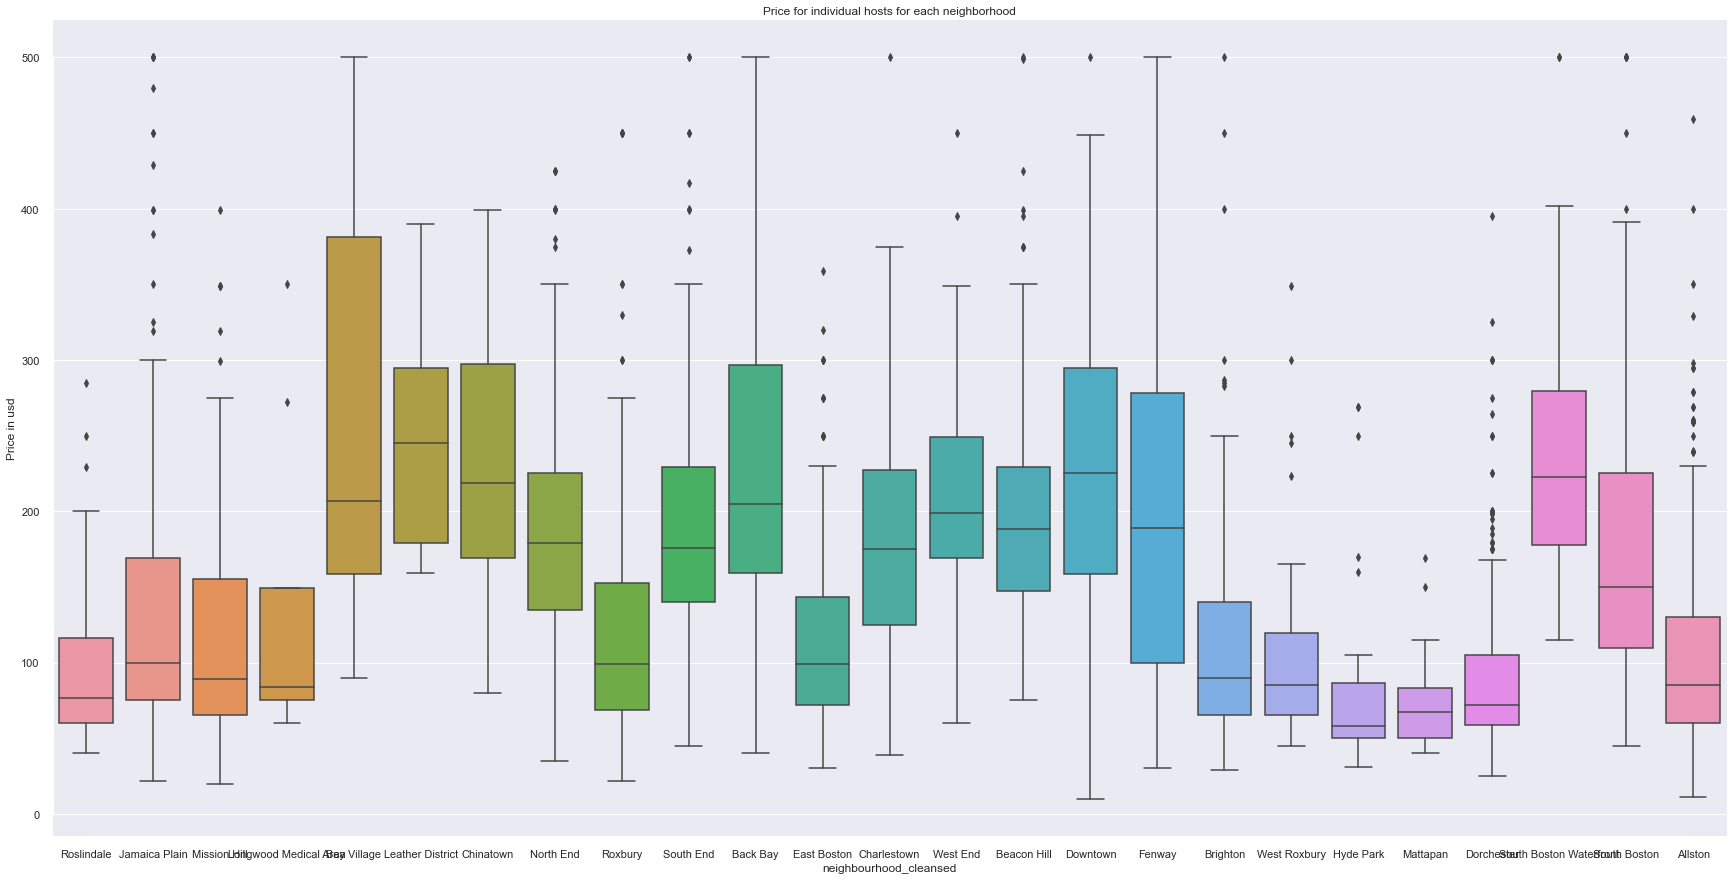

In [30]:
d_dims = (30,15)
fig, ax = plt.subplots(figsize=d_dims)
sns.set_theme(style = 'dark', context="notebook")
sns.set(rc={'figure.figsize':(35,25)})
columns_filter = (listings['price']<=500)
ax = sns.boxplot(data = listings.loc[columns_filter,:], x = 'neighbourhood_cleansed', y = 'price');
ax.set(ylabel = 'Price in usd')
ax.set(title = 'Price for individual hosts for each neighborhood');
sns.despine( trim=True);
fig.savefig('Price neighborhood.png')

#### Prepare Data

In [31]:
active_listings = calendar.loc[calendar['available'] == True,'listing_id'].to_list() # get the list of properties, that were active last year
listings = listings.loc[listings['id'].isin(active_listings),:] # subset by active listings
host_id_counts = listings.groupby('host_id', as_index = False)['id'].count().rename(columns = {'id':'count'}) # count of properties for each host
agents = host_id_counts.loc[host_id_counts['count'] == 1, 'host_id'] # is host has only one property then it's agent, otherwise it's firm
listings['agent'] = np.where(listings['host_id'].isin(agents),'agent','firm') # is host has only one property then it's agent, otherwise it's firm
listings = price_to_int(df = listings) # convert price to int

In [32]:
# subset listing by necessary columns
price_impact = listings.loc[:,['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified',
                              'property_type','accommodates','bathrooms','bedrooms',
                               'beds','bed_type','review_scores_rating','agent','price']]


In [33]:
y = listings.price

In [34]:
price_impact_num = price_impact.select_dtypes(['float', 'int'])
price_impact_num = price_impact_num.loc[:, price_impact_num.columns != 'price']
price_impact_cat = price_impact.select_dtypes(['object'])


In [36]:
def categorize(evc_x):
    
    '''
    This function encode categorical columns.
    If column has two values, then it's hot-encoded, otherwise dummy columns created for each value of a column 
    '''
    
    evc_boolean_columns = evc_x.columns[evc_x.nunique() == 2]
    for t in evc_boolean_columns:
        evc_x[t] = np.where(evc_x[t].isin(['t','agent']), True, False)
    evc_non_boolean_columns = list(evc_x.columns[evc_x.nunique() != 2])
    evc_x = pd.get_dummies(data = evc_x,columns = evc_non_boolean_columns)
    evc_x = evc_x[evc_x.columns[~evc_x.columns.str.contains('NoData')]]
    return evc_x

In [37]:
price_impact_cat = categorize(evc_x = price_impact_cat) # categorize columns
price_impact_cat = price_impact_cat.reset_index().drop('index',axis = 1) # reset index, so it can be merged further

<ipython-input-36-56bec9ae9d0b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evc_x[t] = np.where(evc_x[t].isin(['t','agent']), True, False)


In [51]:
price_impact_num = price_impact_num.reset_index().drop('index',axis = 1)

In [52]:
price_impact = pd.concat([price_impact_cat,price_impact_num], axis = 1) # new categorized price_impact dataset

In [53]:
scaler = preprocessing.StandardScaler().fit(price_impact) # scale values, so that they are of comparable magnitude
price_impact = pd.DataFrame(scaler.fit_transform(price_impact), columns= price_impact.columns)

In [58]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
price_impact = pd.DataFrame(imp.fit_transform(price_impact), columns = price_impact.columns)
# impute missing values with mean

In [59]:
X_train, X_test, y_train, y_test = train_test_split(price_impact, y, test_size=0.1, random_state=42) # split the dataset

In [60]:
# train Random Forest algorithm
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

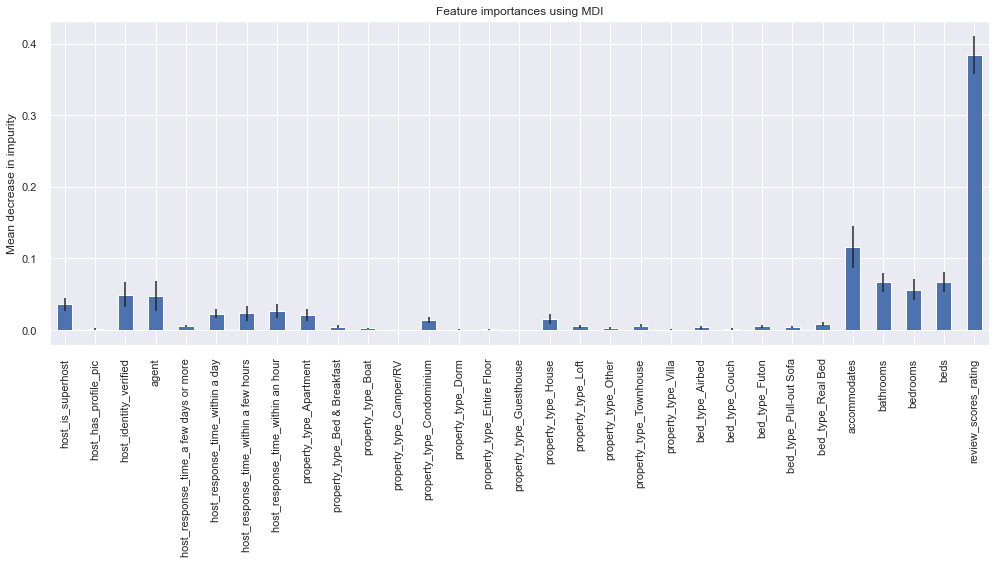

In [61]:
# create the series with feature importance according to Random Forest algorithm
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=price_impact.columns)

# Plot feature importance
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Review_scores_rating is to big, so we drop them

In [62]:
price_impact.drop('review_scores_rating', axis = 1, inplace = True) # drop review_scores_rating

In [63]:
X_train, X_test, y_train, y_test = train_test_split(price_impact, y, test_size=0.1, random_state=42) #split datasets again

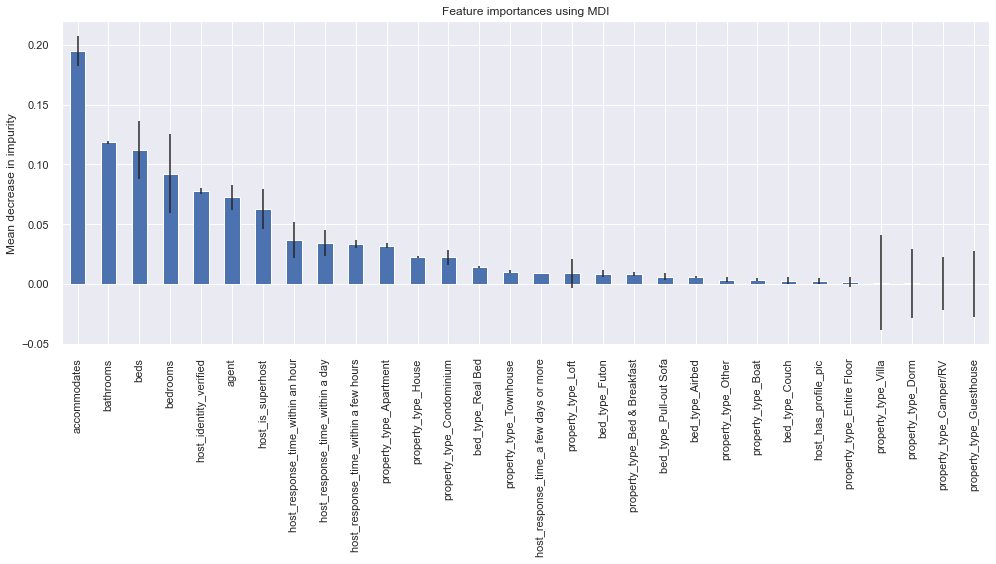

In [64]:
# train Random Forest algorithm again
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

# create the series with feature importance according to Random Forest algorithm
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=price_impact.columns).sort_values(ascending = False)

# Plot feature importance
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.savefig('feature importance.png')

#### Brief: 
* There are three groups of factors that define the price the most: Neighborhood, apartment characteristics and profile of the host

#### Question 3: What is the sentiment difference in apartment descriptions vs reviews by guests?

In [65]:
print(reviews.date.min())
print(reviews.date.max())

2009-03-21
2016-09-06


In [69]:
calendar = calendar.astype({'date':'datetime64[ns]' })
reviews = reviews.astype({'date':'datetime64[ns]'}) # convert date column to datetime

In [68]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68275 non-null  int64         
 1   id             68275 non-null  int64         
 2   date           68275 non-null  datetime64[ns]
 3   reviewer_id    68275 non-null  int64         
 4   reviewer_name  68275 non-null  object        
 5   comments       68222 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.1+ MB


In [70]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308525 entries, 0 to 1308889
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308525 non-null  int64         
 1   date        1308525 non-null  datetime64[ns]
 2   available   1308525 non-null  bool          
 3   price       642957 non-null   float64       
 4   weekday     1308525 non-null  int64         
 5   month       1308525 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 61.1 MB


#### Prepare data

In [72]:
apartments = listings.loc[listings['property_type'] ==  'Apartment','id'].to_list() # collect IDs of apartments
apart_reviews = reviews.loc[reviews['listing_id'].isin(apartments),:].copy() # subset reviews for Apartments only
apart_reviews['comments'] = apart_reviews['comments'].fillna('') # fill empty rows with space, to make them tokenizable
apart_description = listings.loc[listings['property_type'] ==  'Apartment','description'].str.lower().tolist()
apart_comments = apart_reviews['comments'].str.lower().tolist()

In [77]:
def remove_stopwords(sentence):
    '''
    Returns clean tokens. Function start with tokenization of values and after that remove stop words
    '''
    word_tokens = word_tokenize(sentence)  
    clean_tokens = [w for w in word_tokens if not w in stop_words]  
    clean_tokens = [w for w in clean_tokens if not w in ['boston', 'apartment', 'area', 
                                                     'building', 'would', 'place', 'also', 'away', "de'", 's']]
    return clean_tokens

In [78]:
stop_words = stopwords.words('english') # import english stopwords

In [ ]:
comments = '\n'.join(''.join(list(filter(None.__ne__, i))) for i in apart_comments) #join lists of 
comments_x = remove_stopwords(comments)

description = '\n'.join(''.join(list(filter(None.__ne__, i))) for i in apart_description)
description_x = remove_stopwords(description)

#### Analysis of the question 3

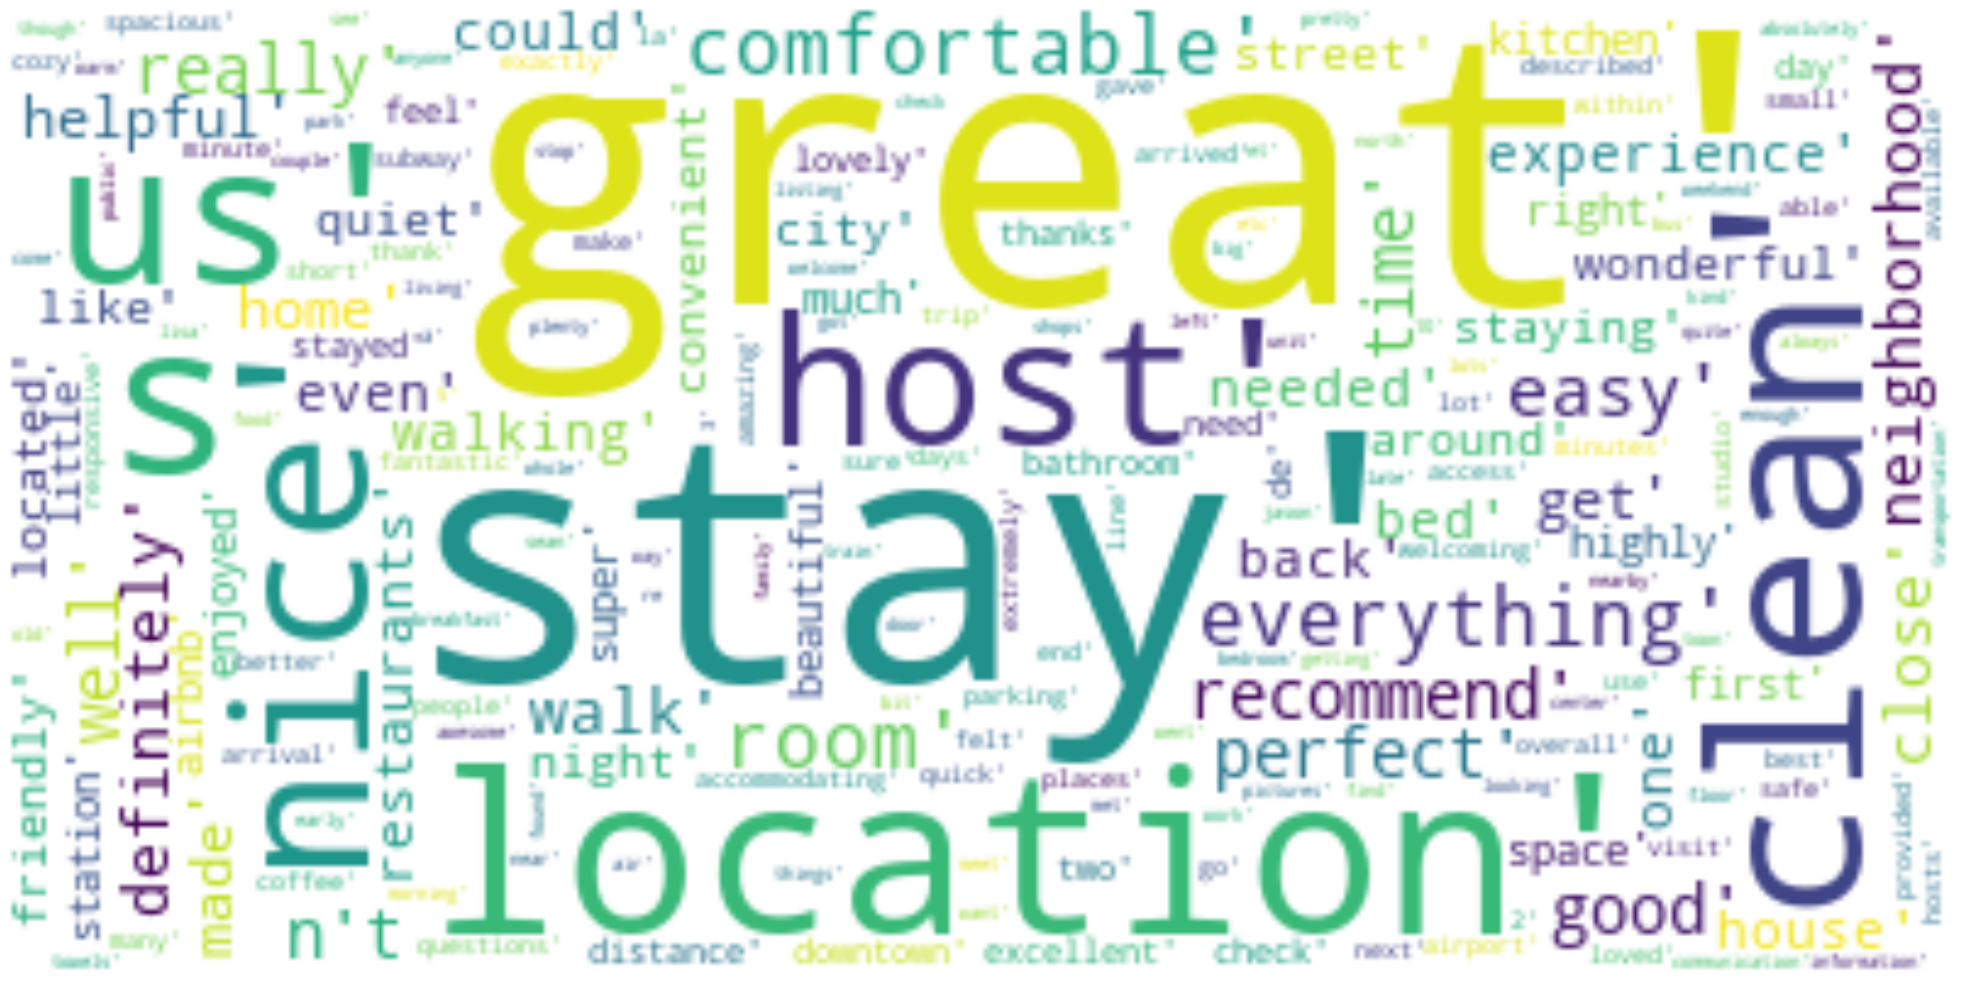

In [79]:
comments_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(comments_x) )
plt.imshow(comments_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_comments.png')
plt.show()


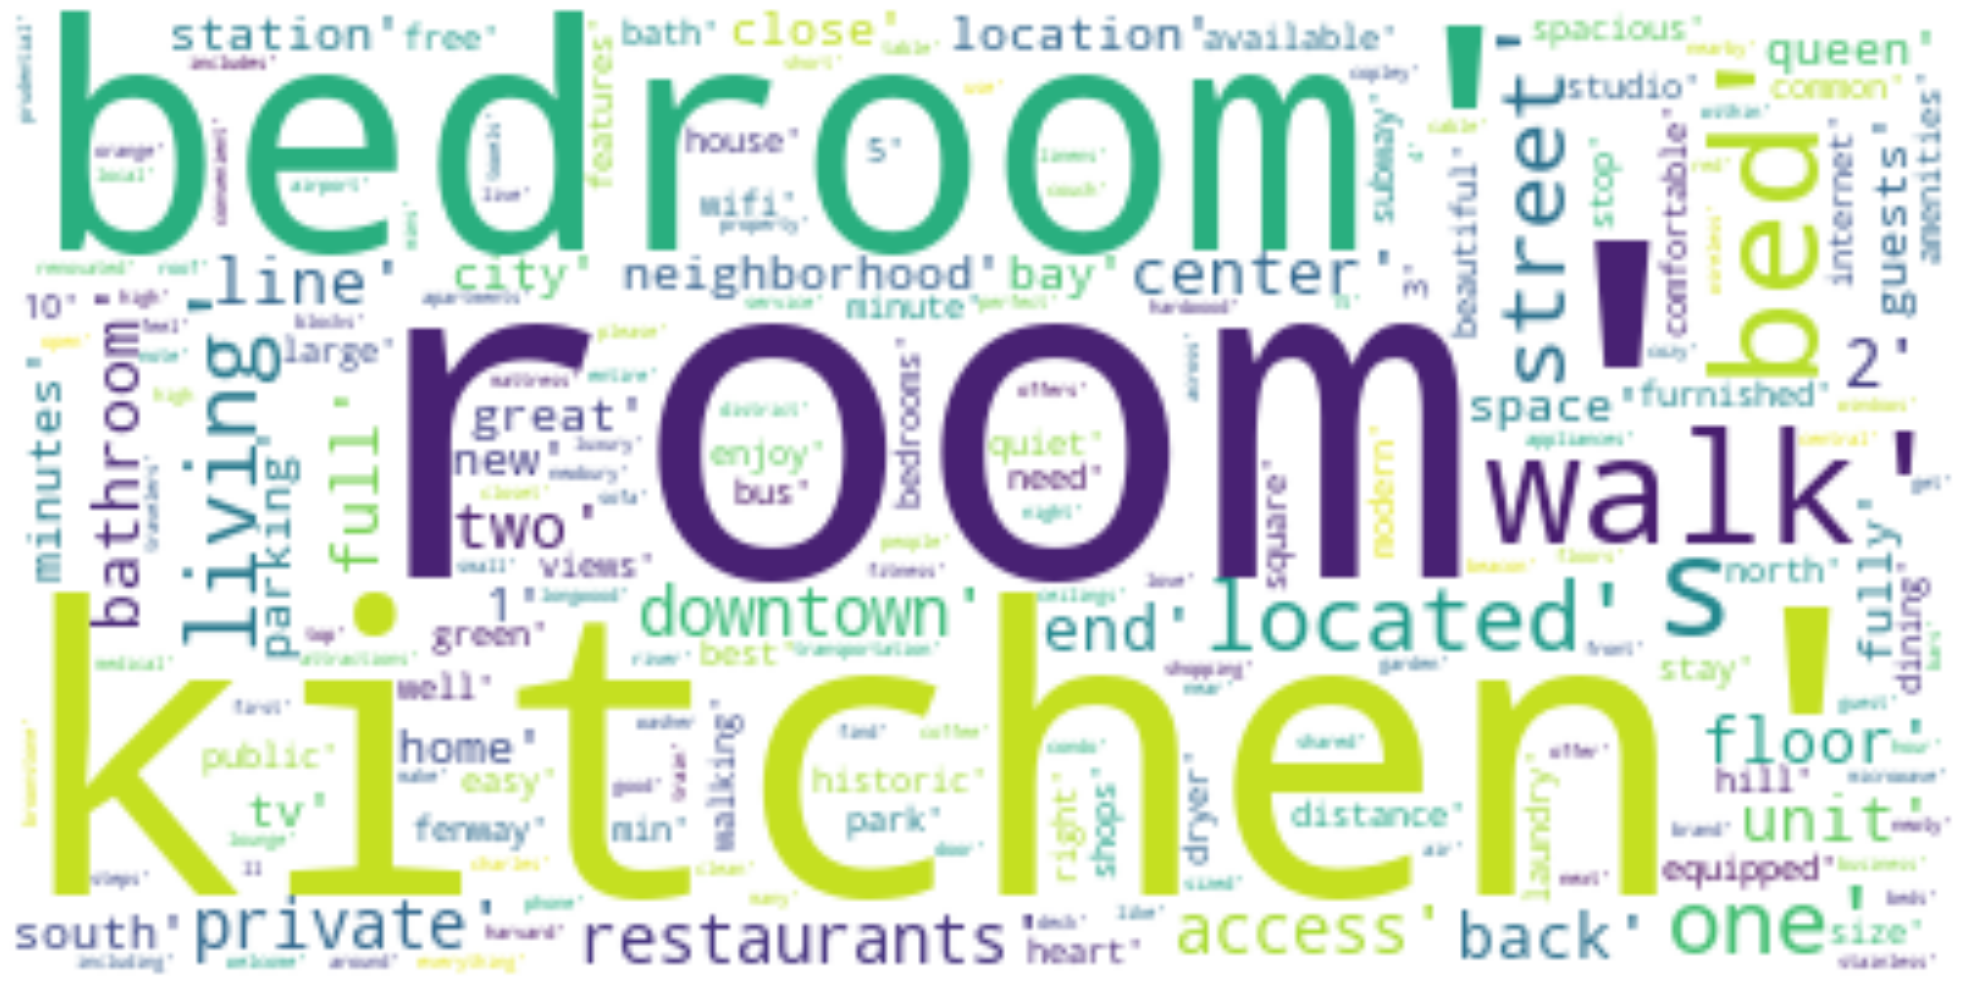

In [80]:
description_word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(description_x) )
plt.imshow(description_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('cloud_description.png')
plt.show()


#### Brief: 

Wordclouds of comments and description by hosts mainly differ by the extent of sentiments:
    * Comments are mainly emotional: great, nice, well are the most used words
    * Description is constructive and focus on description of properties' characteristics